# Feature Preprocessing and Engieneering

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time

from datetime import timedelta

from plotnine import *

The representation of your data can have a bigger influence in the performance of your model than the type of model or the exact hyperparameters you use.

## Pre-processing

Download the data: <br>
https://www.kaggle.com/c/avazu-ctr-prediction

In [2]:
# Too big to read in Google colab.
train_url_unsampled = 'https://drive.google.com/file/d/1A3w1HKMyyih7XjX_tkSSLPb5-6_cQHRC/view'
# 1% sample of data, which is easier to read.
train_url_1p_sample = 'https://drive.google.com/file/d/1GRBfzwkpG7WgIFxRjTml4i1OpbjcB5Ic/view'

In [3]:
def read_csv_from_drive(url: str,
                        usecols: list = None,
                        dtype: list = None) -> pd.DataFrame:
  url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
  return pd.read_csv(url, usecols = usecols, dtype = dtype)

In [4]:
start = time.time()
data0 = read_csv_from_drive(train_url_1p_sample)
print("time in minutes {}".format((time.time() - start) / 60))

time in minutes 0.197243599096934


This data took a while to load. Let's investigate why.

In [5]:
data0.shape

(403726, 24)

In [6]:
data0.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403726 entries, 0 to 403725
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                403726 non-null  uint64
 1   click             403726 non-null  int64 
 2   hour              403726 non-null  int64 
 3   C1                403726 non-null  int64 
 4   banner_pos        403726 non-null  int64 
 5   site_id           403726 non-null  object
 6   site_domain       403726 non-null  object
 7   site_category     403726 non-null  object
 8   app_id            403726 non-null  object
 9   app_domain        403726 non-null  object
 10  app_category      403726 non-null  object
 11  device_id         403726 non-null  object
 12  device_ip         403726 non-null  object
 13  device_model      403726 non-null  object
 14  device_type       403726 non-null  int64 
 15  device_conn_type  403726 non-null  int64 
 16  C14               403726 non-null  int

The raw training data is 6G but pandas is using 26.5 GB. One of the reasons is that pandas is using int64 and object types.

To reduce the memory usage: <br>
1. We can use smaller types for numerical columns. To select the appropiate type read here
https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html. For example int8 is (-128 to 127).
2. Covert categorical variables into categorical type
3. You can drop columns that are not important (for example id)

In [7]:
data0.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10031107759553831604,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
1,10032264153126123156,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,100084,79
2,1005836312304313520,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15702,320,50,1722,0,35,-1,79
3,10059426879354964753,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15708,320,50,1722,0,35,-1,79
4,10068016967403626269,0,14102100,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,...,1,2,15703,320,50,1722,0,35,-1,79


In [8]:
data0.describe() # look at min and max of every colunm. Can we change column types?

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,4.037260e+05,403726.000000,4.037260e+05,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000,403726.000000
mean,9.224630e+18,0.169608,1.410256e+07,1004.968905,0.288899,1.016333,0.332478,18837.079831,318.926202,60.047795,2112.158229,1.433341,227.022721,53116.184667,83.348821
std,5.320059e+18,0.375288,2.965955e+02,1.099322,0.510042,0.531801,0.855863,4963.274922,21.281751,47.341185,609.406743,1.327370,350.798553,49963.122677,70.282664
min,9.849921e+13,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.621055e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.211106e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000
75%,1.383365e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100085.500000,101.000000
max,1.844672e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


In [9]:
data0["device_conn_type"].value_counts()

device_conn_type
0    348175
2     33261
3     21871
5       419
Name: count, dtype: int64

### Reducing memory usage from 25G to 3G.

In [10]:
types = {
    'id': np.uint32,
    'click': np.uint8,
    'hour': np.uint32,
    'C1': np.uint32,
    'banner_pos': np.uint32,
    'site_id': 'category',
    'site_domain': 'category',
    'site_category': 'category',
    'app_id': 'category',
    'app_domain': 'category',
    'app_category': 'category',
    'device_id': 'category',
    'device_ip': 'category',
    'device_model': 'category',
    'device_type': np.uint8,
    'device_conn_type': np.uint8,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

start = time.time()
data = read_csv_from_drive(train_url_1p_sample, usecols = types.keys(), dtype = types)
print("time in minutes {}".format((time.time() - start) / 60))

time in minutes 0.1047540823618571


In [11]:
print(data.info(memory_usage = 'deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403726 entries, 0 to 403725
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                403726 non-null  uint32  
 1   click             403726 non-null  uint8   
 2   hour              403726 non-null  uint32  
 3   C1                403726 non-null  uint32  
 4   banner_pos        403726 non-null  uint32  
 5   site_id           403726 non-null  category
 6   site_domain       403726 non-null  category
 7   site_category     403726 non-null  category
 8   app_id            403726 non-null  category
 9   app_domain        403726 non-null  category
 10  app_category      403726 non-null  category
 11  device_id         403726 non-null  category
 12  device_ip         403726 non-null  category
 13  device_model      403726 non-null  category
 14  device_type       403726 non-null  uint8   
 15  device_conn_type  403726 non-null  uint8   
 16  C1

### Splitting dataset based on time

Here is one example in which we should split the data based on time.

In [12]:
def split_based_hour(data: pd.DataFrame,
                     sort_by: str = 'hour',
                     train_size: float = 0.7,
                     val_size: float = 0.2,
                     drop_columns: list = ['id']) -> tuple:
    """ Split data based on column hour into training, validation and test.

    Argumnents:
       data (pd.DataFrame): Data frame from avazu.
       sort_by (str): Column in data to sort by before splitting.
       train_size (float): Proportion of data to save for training.
       val_size (float): Proportion of data to save for validation.
       drop_columns (list): Columns to drop from data before splitting.
    Returns:
       A tuple containing three data frames:
        train: Data frame with train_size * 100% of the data with the smallest
          number of values in sort_by.
        val: Data frame with val_size * 100%.
        test: Data frame with remaining (1 - train_size - val_size) * 100% of
          data for use in test.
    """

    # Drop any unwanted columns.
    if (len(drop_columns)):
      data = data.drop(columns = drop_columns)

    # N will be the size of the training data.
    N = int(train_size * len(data))

    # First sort the data by sort_by.
    data = data.sort_values(by = sort_by)

    # Make a deep copy of the training data on the first N rows.
    train = data[:N].copy()
    # Make a deep copy of the validation/test data on the remaining N rows.
    val_test = data[N:].copy()
    val_test.reset_index(drop = True, inplace = True)

    # Split into the validation and test data.
    val = val_test.sample(frac = val_size / (1 - train_size))
    test = val_test.drop(val.index)

    return (
        train.reset_index(drop = True),
        val.reset_index(drop = True),
        test.reset_index(drop = True)
    )

In [13]:
train, val, test = split_based_hour(data)

In [14]:
train.shape, val.shape, test.shape

((282608, 23), (80745, 23), (40373, 23))

In [15]:
train.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,20362,320,50,2333,0,39,65535,157
1,0,14102100,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,17914,320,50,2043,2,39,34548,32
2,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15704,320,50,1722,0,35,34548,79
3,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,2,15705,320,50,1722,0,35,34548,79
4,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15707,320,50,1722,0,35,34548,79


## Alternatively: stratify based on hour!!

### Lab activity: stratify and see if model performance changes

## Let's do some EDA

In [16]:
def aggregate_data(data: pd.DataFrame,
                   metric_col: str,
                   by_col: str = None,
                   agg_func: str = 'mean') -> pd.DataFrame:
  """Aggregate CTR by a grouping variable.

  Arguments:
    data (pd.DataFrame): A data frame to aggregate.
    metric_col (list): A column in data to take the average of.
    by_col (list): A list of columns in data to group by. If empty, then
      aggregate the whole data frame.
    agg_func (str): The aggregation function to use.

  Returns:
    A data frame containing the aggregated data.
  """

  # If no splits are provided, create a fake by_cols to group the data.
  if by_col is None:
    data['__by'] = 'by'
    by_col = ['__by']

  # Aggregate the metric column, grouping by the by_cols.
  agg = (
      data
        .groupby([by_col])
        .agg({metric_col: agg_func})
        .reset_index()
        # Sort by the metric column so we can make sure the by_col is also
        # sorted before setting the categories levels.
        .sort_values(by = metric_col)
  )

  if by_col == '__by':
    # Remove the fake column if necessary.
    agg = agg.drop(columns = by_col)
  else:
    # Order the categorical data by the metric column.
    categories = agg[by_col].values.astype(str)
    agg[by_col] = agg[by_col].cat.reorder_categories(categories)

  return agg.reset_index(drop = True)

In [17]:
def my_theme(figure_size: list = (10, 6), font_size: int = 16) -> theme:
  """Create a plotnine theme with larger fonts.

  Args:
    figure_size (list): The size of the figure in inches.
    font_size (int): The size of the font to use in the plot.

  Returns: A plotnine theme
  """

  th = (
      theme_bw() +
      theme(
        figure_size=figure_size,
        legend_position='top',
        legend_box='horizontal',
        legend_direction='horizontal',
        legend_key=element_blank(),
        legend_title=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        axis_line=element_line(size=0.5),
        axis_text=element_text(size=font_size),
        axis_title=element_text(size=font_size),
        strip_text=element_text(size=font_size),
        legend_text=element_text(size=font_size),
        strip_background=element_rect(fill='white'),
      )
  )
  return th

def percent(x: np.array, digits: int = 0) -> np.array:
  """Convert an array of numbers to percentages.

  Args:
    x (np.array): A numeric array.
    digits (int): The number of digits to include after the decimal point.

  Returns:
    A string array with the percentages.
  """

  return [('%0.' + str(digits) + 'f%%') % (v * 100) for v in x]

In [18]:
ctr = aggregate_data(train,
                     metric_col = 'click',
                     by_col = 'site_category',
                     agg_func = 'mean')

ctr.sort_values('click', ascending = False).head()

,site_category,click
18,dedf689d,0.520408
17,42a36e14,0.333333
16,3e814130,0.281524
15,28905ebd,0.213417
14,f028772b,0.184490


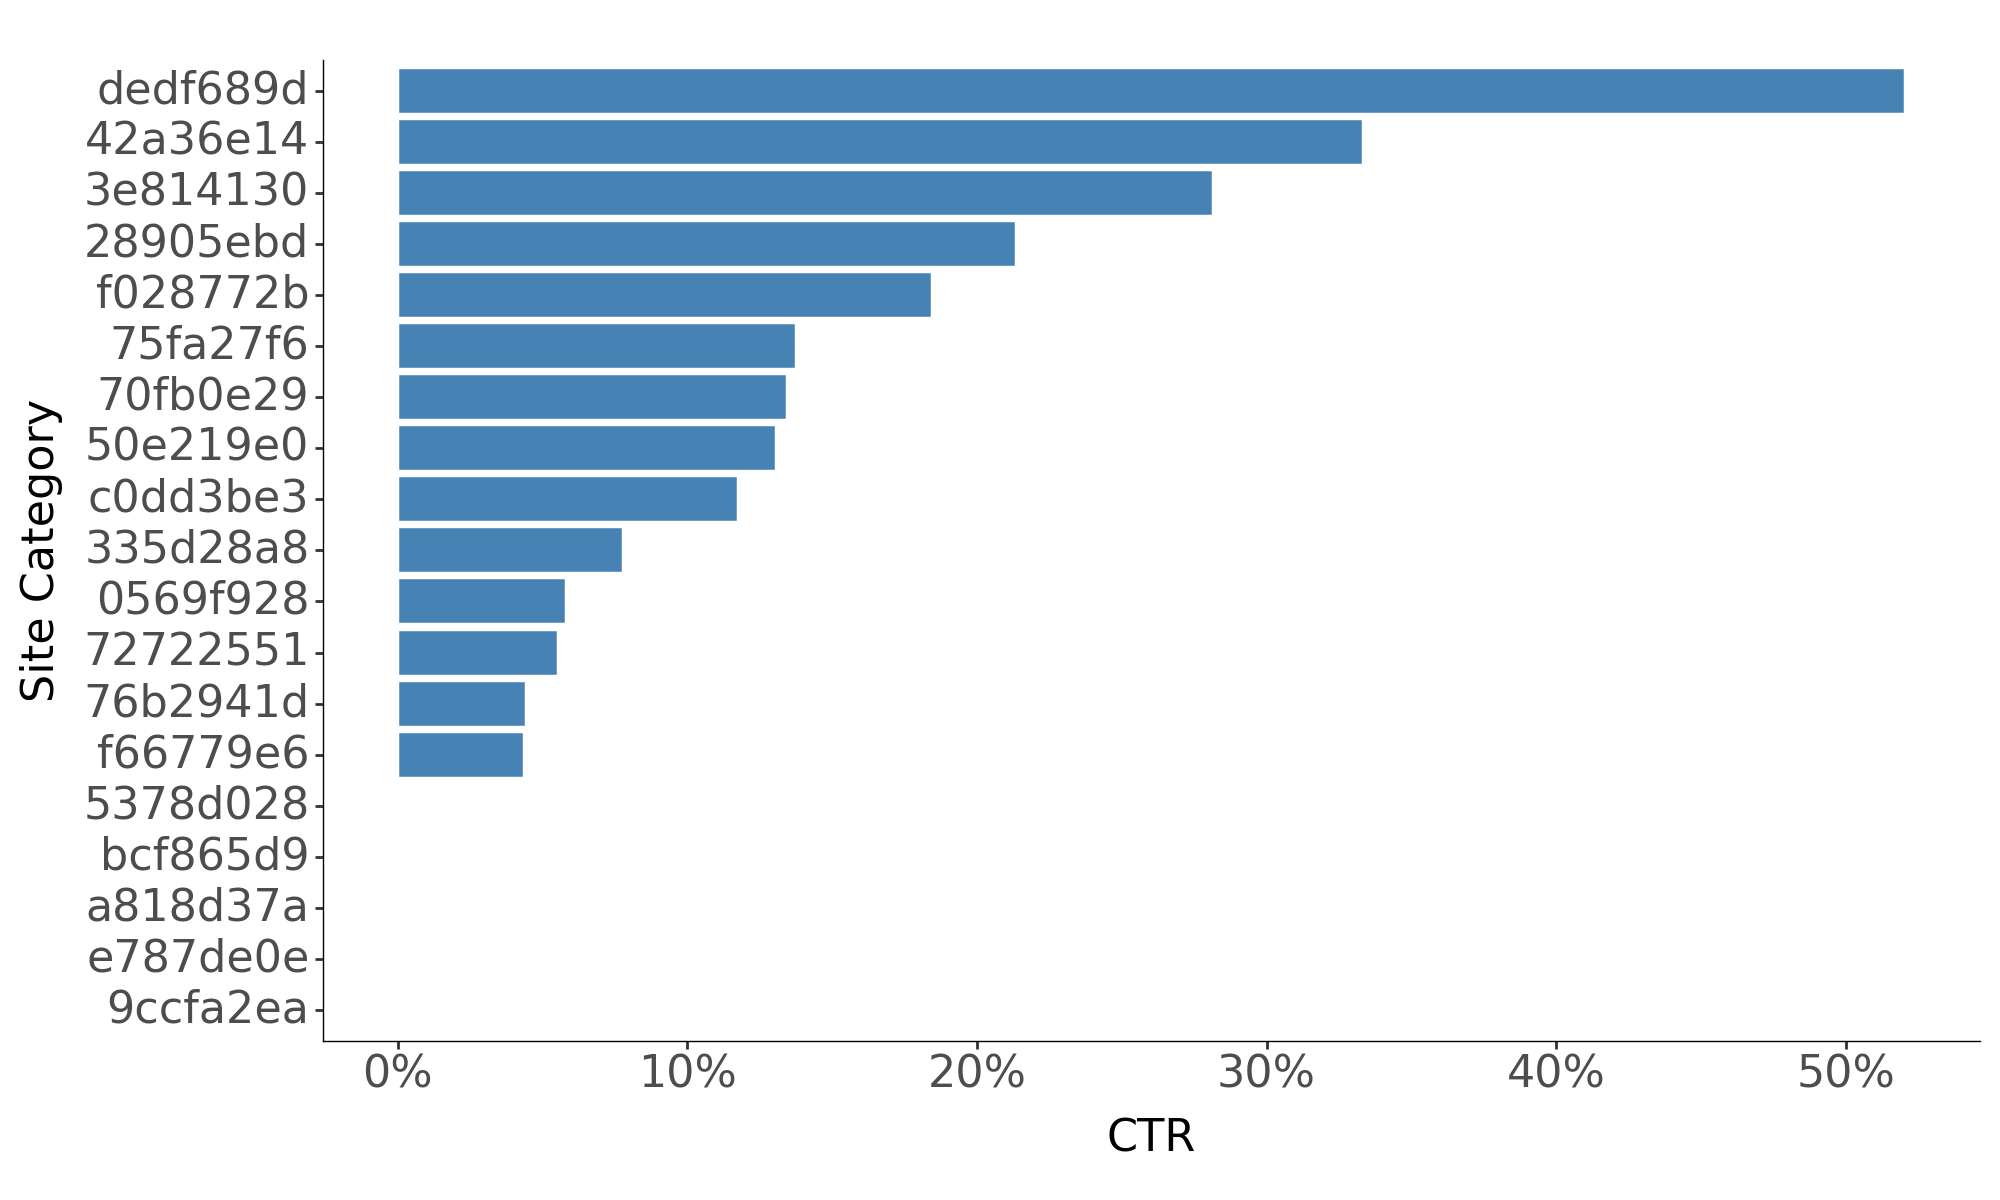

<Figure Size: (1000 x 600)>

In [19]:
(
    ggplot(ctr.dropna(), aes(x = 'site_category', y = 'click')) +
      geom_bar(stat = 'identity', fill = 'steelblue', color = 'white') +
      theme_bw() +
      my_theme() +
      xlab('Site Category') +
      scale_y_continuous(name = 'CTR', labels = lambda l: percent(l)) +
      coord_flip()
)

In [20]:
counts = aggregate_data(train,
                        metric_col = 'click',
                        by_col = 'site_category',
                        agg_func = 'size')

counts.sort_values('click', ascending = False).head()

,site_category,click
19,50e219e0,110973
18,f028772b,88021
17,28905ebd,55108
16,3e814130,23181
15,f66779e6,1973


In [21]:
def group_rare_categories(train: pd.DataFrame,
                          val: pd.DataFrame,
                          col: str,
                          unk_label: str = 'UNK',
                          min_count: int = 100):
    """Group rare labels into an 'unknown' label.

    Arguments:
      train (pd.DataFrame): A data frame containing the training data.
      val (pd.DataFrame): A data frame containing the validation data.
      col (str): The column with the label we're modifying.
      unk_label (str): The new value of the rare labels.
      min_count (int): The threshold we'll use to define 'rare'.

    Returns:
      A data frame with the modified labels.
    """

    # Determine the counts of each level.
    counts = data.groupby([col]).size().reset_index(name='counts')

    ## Apply the threshold.
    top_categories = counts[counts['counts'] > min_count]
    new_categories = top_categories[col].values

    # Change the training column based on threshold.
    train[col] = np.array([
        x if x in new_categories else unk_label for x in train[col].values
    ])

    # Change the validation column based on training threshold.
    val[col] = np.array([
        x if x in new_categories else unk_label for x in val[col].values
    ])

    return train, val

In [22]:
train1, val1 = group_rare_categories(train, val, col = 'site_category', min_count = 100)

In [23]:
freq_counts = train1.groupby(['site_category']).size()

In [24]:
freq_counts = freq_counts / freq_counts.sum()

In [25]:
freq_counts.sort_values()

site_category
UNK         0.000191
70fb0e29    0.000421
0569f928    0.000488
dedf689d    0.000694
72722551    0.000704
c0dd3be3    0.001054
76b2941d    0.002077
75fa27f6    0.003040
335d28a8    0.003192
f66779e6    0.006981
3e814130    0.082025
28905ebd    0.194998
f028772b    0.311460
50e219e0    0.392675
dtype: float64

## Feature Engineering: Frequency encoding

Each category is replaced by the frequency of that category in the training data. Used for tree-based methods.
```
["a", "a", "a", "b", "c"]
```
is encoded as
```
[3/5, 3/5, 3/5, 1/5, 1/5]
```

In [26]:
train1.shape

(282608, 23)

In [27]:
train1['site_category_freq'] = train1['site_category'].map(freq_counts)

In [28]:
val1['site_category_freq'] = val1['site_category'].map(freq_counts)

In [29]:
train1.shape

(282608, 24)

In [30]:
# checking that there are no NAs
val1.site_category_freq.notna().sum(), val1.shape

(80745, (80745, 24))

## Date and time features

* Periodicity
    * Day number in week, month, season, year, second, minute, hour
* Time since
* Difference between dates

In [31]:
train1.hour.unique()

array([14102100, 14102101, 14102102, 14102103, 14102104, 14102105,
       14102106, 14102107, 14102108, 14102109, 14102110, 14102111,
       14102112, 14102113, 14102114, 14102115, 14102116, 14102117,
       14102118, 14102119, 14102120, 14102121, 14102122, 14102123,
       14102200, 14102201, 14102202, 14102203, 14102204, 14102205,
       14102206, 14102207, 14102208, 14102209, 14102210, 14102211,
       14102212, 14102213, 14102214, 14102215, 14102216, 14102217,
       14102218, 14102219, 14102220, 14102221, 14102222, 14102223,
       14102300, 14102301, 14102302, 14102303, 14102304, 14102305,
       14102306, 14102307, 14102308, 14102309, 14102310, 14102311,
       14102312, 14102313, 14102314, 14102315, 14102316, 14102317,
       14102318, 14102319, 14102320, 14102321, 14102322, 14102323,
       14102400, 14102401, 14102402, 14102403, 14102404, 14102405,
       14102406, 14102407, 14102408, 14102409, 14102410, 14102411,
       14102412, 14102413, 14102414, 14102415, 14102416, 14102

In [32]:
# hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
train1['hour_enc'] = train1['hour'].astype(str).str[-2:].astype(float)
val1['hour_enc'] = val1['hour'].astype(str).str[-2:].astype(float)
train1.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C14,C15,C16,C17,C18,C19,C20,C21,site_category_freq,hour_enc
0,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,20362,320,50,2333,0,39,65535,157,0.082025,0.0
1,0,14102100,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,17914,320,50,2043,2,39,34548,32,0.311460,0.0
2,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,15704,320,50,1722,0,35,34548,79,0.194998,0.0
3,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,15705,320,50,1722,0,35,34548,79,0.194998,0.0
4,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,15707,320,50,1722,0,35,34548,79,0.194998,0.0


## Feature Engineering: Target or mean encoding
Use the target varible to generate features

In [33]:
states = pd.DataFrame({
        'state': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
        'y': [1, 1, 0, 0, 0]})
states

,state,y
0,Ohio,1
1,Ohio,1
2,Ohio,0
3,Nevada,0
4,Nevada,0


In [34]:
m = states['y'].groupby(states['state']).mean()
m

state
Nevada    0.000000
Ohio      0.666667
Name: y, dtype: float64

In [35]:
states['state_mean_enc'] = states['state'].map(m)
states

,state,y,state_mean_enc
0,Ohio,1,0.666667
1,Ohio,1,0.666667
2,Ohio,0,0.666667
3,Nevada,0,0.000000
4,Nevada,0,0.000000


In [36]:
mean_site_cat = train1['click'].groupby(train1['site_category']).mean()

In [37]:
mean_site_cat

site_category
0569f928    0.057971
28905ebd    0.213417
335d28a8    0.077605
3e814130    0.281524
50e219e0    0.130581
70fb0e29    0.134454
72722551    0.055276
75fa27f6    0.137369
76b2941d    0.044293
UNK         0.111111
c0dd3be3    0.117450
dedf689d    0.520408
f028772b    0.184490
f66779e6    0.043588
Name: click, dtype: float64

In [38]:
train1['site_category_mean_enc'] = train1['site_category'].map(mean_site_cat)

In [39]:
val1['site_category_mean_enc'] = val1['site_category'].map(mean_site_cat)

Note that mean encodoing needs to be computed on train and joined latter with validation and test.

Regularized mean encoding for the homework.

## Aggregate by one or multiple categorical features

Here are some fetures that we can compute
* Number of times `device_ip` appears on the training data. It would be better if we had `user_id`.
* Number of times `device_ip` appears per month on the training data.
* Min, max, average `C1` per `site_id`.

We can compute these features using `groupby` to aggregate to a new dataframe and then use `merge` to make the new feature.

### Categorical encoding can be slow. Let's three options

In [40]:
def hash_encode_cols(train, val, col):
    print('Encoding column ', col)
    train[col] = train[col].apply(hash).astype('int32')
    val[col] = val[col].apply(hash).astype('int32')

In [41]:
def label_encoding_with_NAs(train, val, col):
    train[col] = train[col].astype('category').cat.as_ordered()
    encoder = train[col].cat.categories
    # leaving 0 for NAs
    train[col] = train[col].cat.codes + 1
    val[col] = pd.Categorical(val[col], categories=encoder, ordered=True)
    val[col] = val[col].cat.codes + 1

In [42]:
t = pd.DataFrame({'x': ['a', 'b', 'c']})
v = pd.DataFrame({'x': ['a', 'b', 'd', 'f']})

In [43]:
t['x_enc'] = t['x'].astype('category').cat.as_ordered()
encoder = t['x_enc'].cat.categories

In [44]:
v['x_enc'] = pd.Categorical(v['x'], categories=encoder, ordered=True)

In [45]:
t['x_enc'] = t['x_enc'].cat.codes + 1
t

,x,x_enc
0,a,1
1,b,2
2,c,3


In [46]:
v['x_enc'] = v['x_enc'].cat.codes + 1

In [47]:
v

,x,x_enc
0,a,1
1,b,2
2,d,0
3,f,0


In [50]:
from sklearn.preprocessing import LabelEncoder
def label_encoding_with_UNK(train, val, col, UNK=True):
    """ Returns a label encoding "UNK" values
    """
    le = LabelEncoder()
    uniq = np.unique(train[col])
    if UNK:
        uniq = np.concatenate((np.array(["UNK"]),uniq))
    le.fit(uniq)
    train[col] = le.transform(train[col])
    # this is very slow
    val_col = [x if x in le.classes_ else 'UNK' for x in val[col]]
    val[col] = le.transform(val_col)

In [69]:
col = 'device_model'
t1 = train1[[col, 'click']].copy()
v1 = val1[[col, 'click']].copy()

(
    t1
      .groupby(['device_model'])
      .agg({'click': 'sum'})
      .reset_index()
      .sort_values('click', ascending = False)
)

,device_model,click
1171,8a4875bd,2409
1870,d787e91b,2257
275,1f0bc64f,2206
1015,76dc4769,1062
692,4ea23a13,1051
...,...,...
2661,c10aa1ff,0
2660,c0b8dac3,0
2659,c088ace8,0
2658,c00022b2,0


In [70]:
start = time.time()
label_encoding_with_UNK(t1, v1, col)
print((time.time() - start) / 60)

0.21592687765757243


In [71]:
(
    t1
      .groupby(['device_model'])
      .agg({'click': 'sum'})
      .reset_index()
      .sort_values('click', ascending = False)
)

,device_model,click
2168,2168,2409
3410,3411,2257
473,473,2206
1866,1866,1062
1242,1242,1051
...,...,...
2815,2816,0
1335,1335,0
2813,2814,0
1340,1340,0


In [72]:
t2 = train1[[col, 'click']].copy()
v2 = val1[[col, 'click']].copy()

In [73]:
start = time.time()
hash_encode_cols(t2, v2, col)
print((time.time() - start) / 60)

Encoding column  device_model
0.00026981433232625327


In [75]:
(
    t2
      .groupby(['device_model'])
      .agg({'click': 'sum'})
      .reset_index()
      .sort_values('click', ascending = False)
)

,device_model,click
873,-1234771776,2409
461,-1672205310,2257
3529,1569651037,2206
2446,366560744,1062
1975,-119788112,1051
...,...,...
2387,310479689,0
2386,310206799,0
2385,309232112,0
2384,308397654,0


In [76]:
col = 'device_model'
t3 = train1[[col, 'click']].copy()
v3 = val1[[col, 'click']].copy()
start = time.time()
label_encoding_with_NAs(t3, v3, col)
print((time.time() - start) / 60)

6.587902704874674e-05


In [77]:
(
    t3
      .groupby(['device_model'])
      .agg({'click': 'sum'})
      .reset_index()
      .sort_values('click', ascending = False)
)

,device_model,click
1171,1172,2409
1870,1871,2257
275,276,2206
1015,1016,1062
692,693,1051
...,...,...
2889,2890,0
1393,1394,0
388,389,0
1402,1403,0


In [255]:
col = 'device_model'
hash_encode_cols(train1, val1, col)

Encoding column  device_model


## BABY Baseline random forest model

In [256]:
features = ['site_category_freq', 'hour_enc', 'site_category_mean_enc', 'device_model']

In [257]:
y_train = train1.click.values
y_val = val1.click.values

In [259]:
x_train = train1[features]
x_val = val1[features]
x_train.head()

,site_category_freq,hour_enc,site_category_mean_enc,device_model
0,0.082025,0.0,0.281524,-1802734913
1,0.311460,0.0,0.184490,340519092
2,0.194998,0.0,0.213417,574782209
3,0.194998,0.0,0.213417,-899406932
4,0.194998,0.0,0.213417,1221781647


In [260]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [269]:
def get_random_values_hyperparameters(min_samples_leaf_range: list = [50, 100],
                                      max_features_range: list = [0.1, 0.6],
                                      max_depth_range: list = [6, 20],
                                      seed: int = 8675309) -> tuple:
    np.random.seed(seed)

    min_samples_leaf = np.random.randint(
        low = min_samples_leaf_range[0],
        high = min_samples_leaf_range[1])
    max_features = np.random.uniform(
        low = max_features_range[0],
        high = max_features_range[1])
    max_depth = np.random.randint(
        low = max_depth_range[0],
        high = max_depth_range[1])

    return min_samples_leaf, max_features, max_depth

In [270]:
get_random_values_hyperparameters()

(51, 0.5158356962764452, 6)

In [279]:
# you want to look for the simplest model with the best val AUC or val loss

loss_train = []
roc_auc_train = []

loss_val = []
roc_auc_val = []

min_samples_leaf = [],
max_features = []
max_depth = []

M = 10

for i in range(M):
    min_samples_leaf_i, max_features_i, max_depth_i = (
        get_random_values_hyperparameters(seed = i)
    )

    rf = RandomForestClassifier(
        n_jobs = -1,
        n_estimators = 20,
        min_samples_leaf = min_samples_leaf_i,
        max_features = max_features_i,
        max_depth = max_depth_i,
        random_state = i,
        verbose = 1)

    rf.fit(x_train, y_train)

    y_hat_train = rf.predict_proba(x_train)[:,1]
    y_hat_val = rf.predict_proba(x_val)[:,1]

    loss_train_i = log_loss(y_train, y_hat_train)
    roc_auc_train_i = roc_auc_score(y_train, y_hat_train)

    loss_val_i = log_loss(y_val, y_hat_val)
    roc_auc_val_i = roc_auc_score(y_val, y_hat_val)

    loss_train = np.append(loss_train, loss_train_i)
    roc_auc_train = np.append(roc_auc_train, roc_auc_train_i)

    loss_val = np.append(loss_val, loss_val_i)
    roc_auc_val = np.append(roc_auc_val, roc_auc_val_i)

    min_samples_leaf = np.append(min_samples_leaf, min_samples_leaf_i)
    max_features = np.append(max_features, max_features_i)
    max_depth = np.append(max_depth, max_depth_i)

    print('min_samples_leaf %d, max_features %.1f, max_depth %d' %
          (min_samples_leaf_i, max_features_i, max_depth_i))
    print('   train loss %.2f, val loss %.2f' % (loss_train_i, loss_val_i))
    print('   train auc %.2f, val auc %.2f' % (roc_auc_train_i, roc_auc_val_i))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 94, max_features 0.4, max_depth 6
   train loss 0.45, val loss 0.43
   train auc 0.61, val auc 0.60


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 87, max_features 0.6, max_depth 14
   train loss 0.44, val loss 0.42
   train auc 0.65, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 90, max_features 0.2, max_depth 14
   train loss 0.44, val loss 0.42
   train auc 0.65, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 92, max_features 0.1, max_depth 9
   train loss 0.45, val loss 0.43
   train auc 0.62, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.1s finished


min_samples_leaf 96, max_features 0.4, max_depth 7
   train loss 0.45, val loss 0.43
   train auc 0.61, val auc 0.60


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 85, max_features 0.1, max_depth 19
   train loss 0.44, val loss 0.43
   train auc 0.66, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


min_samples_leaf 60, max_features 0.6, max_depth 10
   train loss 0.45, val loss 0.42
   train auc 0.63, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


min_samples_leaf 97, max_features 0.2, max_depth 12
   train loss 0.45, val loss 0.42
   train auc 0.64, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


min_samples_leaf 53, max_features 0.1, max_depth 15
   train loss 0.44, val loss 0.42
   train auc 0.66, val auc 0.61


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


min_samples_leaf 78, max_features 0.4, max_depth 12
   train loss 0.45, val loss 0.42
   train auc 0.64, val auc 0.61


In [290]:
rf_par = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'max_depth': max_depth,
    'loss_train': loss_train,
    'loss_val': loss_val,
    'roc_auc_train': roc_auc_train,
    'roc_auc_val': roc_auc_val
})

In [291]:
rf_par[rf_par['roc_auc_val'] == max(rf_par['roc_auc_val'])]

,min_samples_leaf,max_features,max_depth,loss_train,loss_val,roc_auc_train,roc_auc_val
1,87.0,0.598592,14.0,0.441495,0.423733,0.65402,0.61219


In [292]:
rf_par[rf_par['loss_val'] == min(rf_par['loss_val'])]

,min_samples_leaf,max_features,max_depth,loss_train,loss_val,roc_auc_train,roc_auc_val
1,87.0,0.598592,14.0,0.441495,0.423733,0.65402,0.61219
